# What the heck are priors, and how to choose them?

As a crucial part of the Bayesian workflow and Bayes formula, priors are loved, hated and dreaded at the same time. In the end though, all the fuss is unwarranted: priors are just hypotheses, and hypotheses can be tested and refined.

This already answers the main question we hear from beginners: "what's the best prior?". Remember that: there are bad priors, but there is no one best prior. You're never tied to a prior, you can always change it if it's warranted.

And that's a beauty of the Bayesian framework: you get to be more creative, because you can explore different hypotheses. This requires learning _principles_ instead of _techniques_. Once you understand those core principles, you can always combine them to creatively answer your questions. Whereas, if you focus on techniques, you're lost the day you don't have the technique that exactly fits your problem.

However, learning those principles can be intimidating and overwhelming at first. This notebook will guide through that process. We'll learn:
- Some common priors for common use-cases
- How to choose priors visually
- How to choose priors computationally

## 1. Know your classics

In [1]:
import arviz as az
import numpy as np
import pymc as pm

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

The first prior you have to choose is usually the... likelihood. And a good question to ask is often: "**where do my data live?**". Are they continuous or discrete? 

If it's on the real line, then a Normal or Student-T distribution should work. If the variable can only take positive integer values, like a count variable, then the Normal probably won't be appropriate. Same thing if your variable represents a percentage or proportion.

Here is an example of a decision tree to choose your likelihood. Again, this is not exhaustive and you should not feel yourself constrained to these choices, but this should give you an idea of the possibilities.

![image](images/likelihood.png)


This branches out into several other questions, an example of which you can see below:

Interestingly, the reasoning is the same for the prior on your model parameters, because, in the end, the likelihood is just a prior... for the data. So here, the first question is similar: "**in which space are my parameters living in?**". If they are just continuous, a Normal or Student-T should work. If the variable can only take positive values, like a variance term for instance, then the Normal won't work. Same thing if your variable represents a percentage or proportion.

This branches out into several other questions, an example of which you can see below:

![image](images/priors.png)

Afraid? Rest assured: it's not an infinite choice paradox; usually it's obvious what we want to choose. Yes, there are a lot of possible options (and you'll come to love the flexibility it gives you), but the rule of thumb is: pick the most obvious one -- your priors don't need to be perfect; they just need to be good enough.

### Summary
- Choosing priors comes down to asking questions about your data and parameters.
- You don't need to know every distribution that is out there in the wild!
- Because 99% of the time, you will only need those from the [exponential family](https://en.wikipedia.org/wiki/Exponential_family). You got a glimpse of those distributions here.
- Related to this: you don't need to nail the perfect prior for your model to run and give reasonable inferences. Your priors just need to be like Sir [John](https://en.wikipedia.org/wiki/John_B._Goodenough) -- good enough.
- Don't be afraid to change and experiment with your priors -- they are just hypotheses after all!

## 2. Choosing priors visually

Now that we know which distribution we want to use as prior, how do we parametrize it? A versatile way of doing this is to sample from this distribution with given parameters, see how that looks, and relate that to our problem.

For instance, let's say we're trying to infer the height of women. Height is positive, continuous and somewhat symmetrical. And it's so far from zero that the positivity constraint should be an issue if we use a **Normal prior**. So let's try that!

Let's first randomly sample from a Normal with mean 170cm and standard deviation 2:

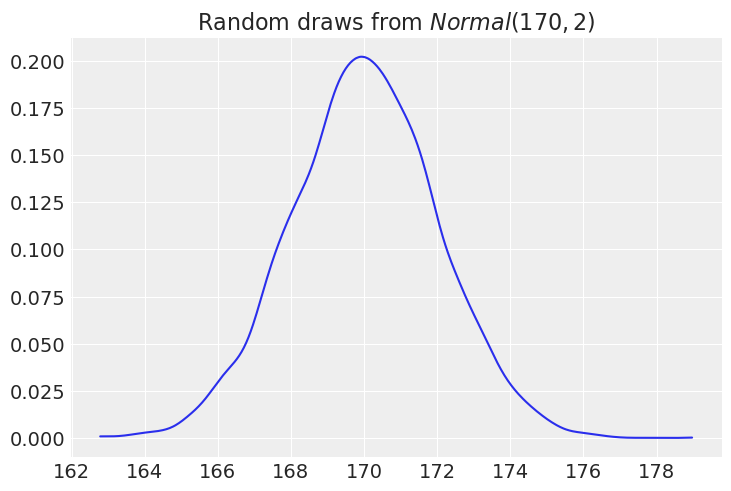

In [3]:
ax = az.plot_dist(pm.draw(pm.Normal.dist(170, 2), draws=10_000))
ax.set_title("Random draws from $Normal(170, 2)$");

That looks OK, but is very probably under-estimating the variance of women's heights. We can do better! But let's do that in your favorite room -- breakout rooms!

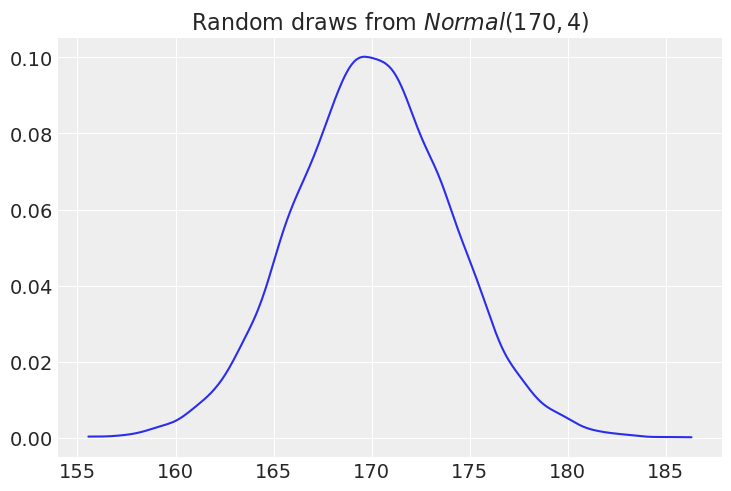

In [4]:
ax = az.plot_dist(pm.draw(pm.Normal.dist(170, 4), draws=10_000))
ax.set_title("Random draws from $Normal(170, 4)$");

That's much better! I'd use that in my model.

Another example: let's say that we need a prior over a conversion rate. That's a percentage, by definition. Remember which distribution is useful in those cases? Yep, the **Beta distribution**, because its support is restricted to $[0, 1]$, exactly like percentages (in statistics we usually have percentages go from 0 to 1 rather than 0% to 100%).

Beta distributions are parametrized by two positive reals, $\alpha$ and $\beta$, which, luckily, have a very direct interpretation: the number of 0s or 1s you observe (e.g. before running the experiment). 

For the sake of completeness, we'll show you another parametrization here, which is often useful too: $p$ and $\theta$, which roughly correspond to the mean and precision (aka sample size) respectively: for a given $p$, a higher $\theta$ means that we are more skeptical of very weak or very strong probabilities -- those near 0 or 1. You can take a look at the parametrization on [Wikipedia](https://en.wikipedia.org/wiki/Beta_distribution#Mean_and_sample_size).

For $\theta$, a value of 2 translates to a uniform prior over probabilities. Let's see how this manifests visually, with a mean conversion rate of 50%:

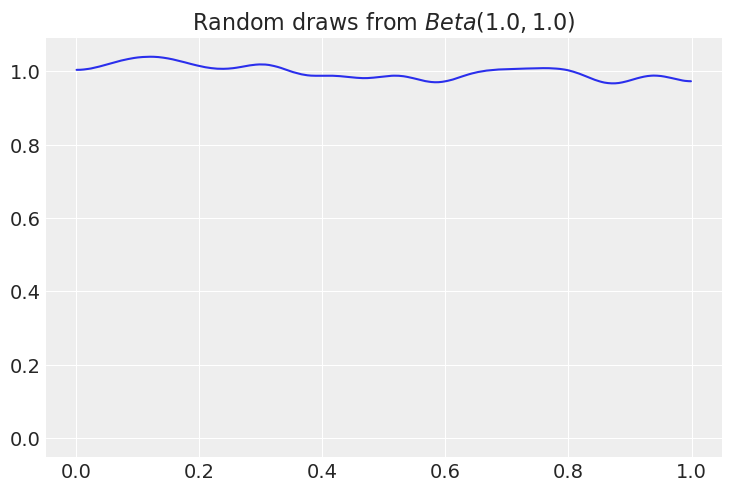

In [5]:
pbar = 0.5
theta = 2.0

ax = az.plot_dist(
    pm.draw(pm.Beta.dist(alpha=pbar * theta, beta=(1 - pbar) * theta), draws=10_000)
)
ax.set_title(f"Random draws from $Beta({pbar * theta}, {(1 - pbar) * theta})$");

That's basically a uniform distribution, and is rarely what we want, because we almost always have more information. Here for instance, we know a mean conversion rate around 10% seems more reasonable than 50% -- that's our prior for $p$.

We also know that conversion rates are usually small and don't often go above 50%. To get that, we can set $\theta = 10$. You can play around with the code below to get a sense of how the Beta family behaves. Actually you _will_ play about with that code to come up with a better prior -- breakout rooms!

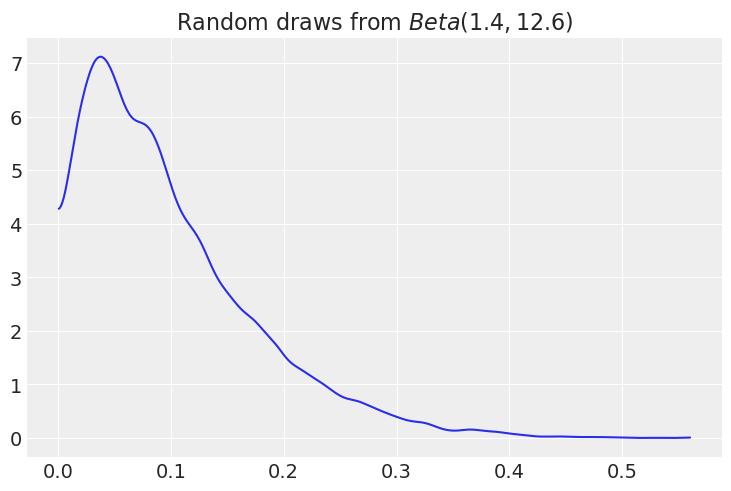

In [6]:
pbar = 0.1
theta = 14.0

ax = az.plot_dist(
    pm.draw(pm.Beta.dist(alpha=pbar * theta, beta=(1 - pbar) * theta), draws=10_000)
)
ax.set_title(
    f"Random draws from $Beta({round(pbar * theta, 1)}, {round((1 - pbar) * theta, 1)})$"
);

Looks much better, right? We could then use this sensible prior in our model!

---

_If you're interested, you can see that the mathematical link between $(p, \theta)$ and $(\alpha, \beta)$ is quite simple:_

$$ \alpha = p \times \theta $$
$$ \beta = (1 - p) \times \theta $$

---

We showed you two examples, but you get the gist, right? Take any distribution you're interested in (it will usually be available in `scipy.stats` or `numpy.random`), sample from it, see how that looks and how that relates to your use-case. 

This simple step will already give you sensible priors most of the time, and will help you better understand your model at the same time.

**A word of caution**: this method is helpful when we care about just one parameter, but as we go and create generalized linear models (which use link functions, distorting the link between the parameter space and the outcome space) or hierarchical models, choosing priors in isolation to each other will become more and more difficult. Instead, we'll care more about how all the parameters interact and the effect that has on the outcome space. That's when drawing **prior predictive samples** will help with choosing the priors. We'll see that in the notebook dealing with hierarchical models.

### A note about informative priors

There is a lot of talk about "uninformative" priors and "letting the data speak for themselves". But often, all the information is not in the data. And what happens if your data are untrusworthy (missing, compromised, etc.)? "Letting them speak" and, most importantly, believing what they say blindly, is probably not the right thing to do here.

#### Show me your wallet

Let me ask you: how much cash do you think I have in my wallet right now? You probably already have a lower bound on that number -- 0€. And what about the upper bound? I'm in a Euro country, so I very probably don't have more than 1000€ on me -- and I'm not German, so I probably have even less.

The point is: we already have a prior for our answer ($[0, 1000]$, with more probablity mass for values in the middle of the interval), but we used domain knowledge to set it up. If we had only relied on the data to come up with our prior, we'd have had a _huge_ interval, because the data didn't have any information -- that would have been an uninformative prior, yes, but mainly it'd have been a stupid prior, because estimates can _very_ rarely plausibly take _any_ value.

#### Are you sure you're _that_ smart?

A good, real example is that of IQ. Imagine that we measured the IQ of an individual at 180. We know there is measurement noise, so we should already be skeptical. A quick internet search will inform us that IQ was constructed so as to have [a mean of 100 and a standard deviation of 15](https://www.davidsongifted.org/gifted-blog/iq-and-educational-needs/), so we're even more skeptical now: an IQ of 180 is _very_ unlikely, and we should tell that to our model.

How? With our prior! We'll use a $Normal(100, 15)$ as our prior for individual IQ, which will make the model more skeptical of extreme observations -- i.e, it will need more convincing data to make extreme inferences. That's another version of the colloquial "extraordinary claims require extraordinary evidence". Logical, right? In the Bayesian framework, we say that **the actual estimate of IQ will get regularized towards 100**.

Let's illustrate with a very simple model and a very uninformative prior to begin with:

In [7]:
with pm.Model() as m:
    iq = pm.Normal("iq", 100, 100)
    eps = 30  # we assume we know our measurement error

    obs = pm.Normal("obs", iq, eps, observed=180)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [iq]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


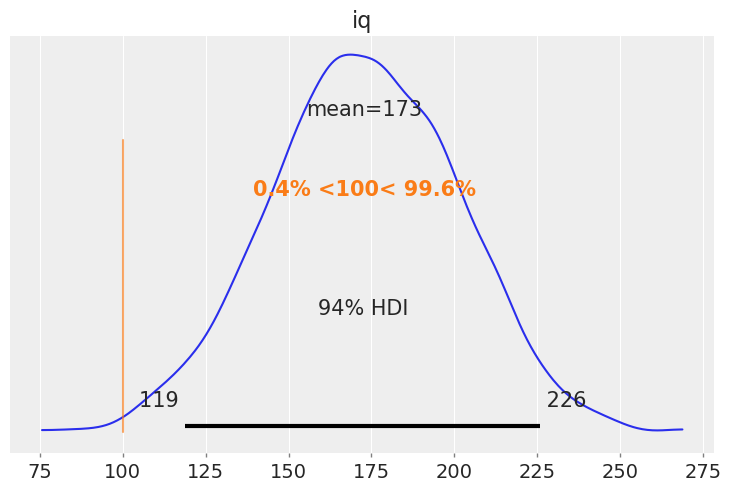

In [8]:
az.plot_posterior(idata, ref_val=100);

It's very clear our model gets swayed by any data you throw at it, even with a big measurement error and only one observation! As a modeler, you don't want that.

Now what happens with our informative prior?

In [9]:
with pm.Model() as m:
    iq = pm.Normal("iq", 100, 15)
    eps = 30  # we assume we know our measurement error

    obs = pm.Normal("obs", iq, eps, observed=180)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [iq]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


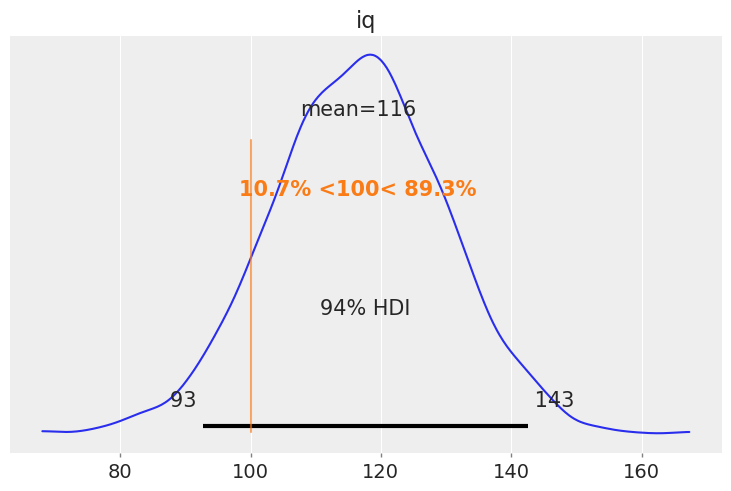

In [10]:
az.plot_posterior(idata, ref_val=100);

That looks more sensible, right? Our model needs more data to say that this person has an extremly high IQ. It's more probable (88%) that the person has a higher than average IQ, but not with the magnitude suggested by the data. There is even still a chance (12%) that the subject is below average. Remember: with big measurement error and only one data point, there is still a lot of uncertainty.

To sum up, **informative priors are helpful because they regularize your inferences** in a smart, principled and customizable way, as hierarchical models perfectly examplify.

## 3. Choosing priors computationally

Sometimes though, you won't have enough information to parametrize your priors efficiently. This can happen especially for the Gamma and Beta distributions, which are particularly versatile. So, if the only prior information you've got is "**I need a Gamma that has 95% probability mass between 0.1 and 0.4**", it may take you a long time to find an appropriate combination of parameters that give you a decent Gamma -- the drawback of this flexibility.

But don't despair: we can use optimization! In our case, we can ask scipy's optimizer: "**What are the $\alpha$ and $\beta$ parameters that fit this constraint?**".

There is a brand new function to do just that in PyMC 4.0:

In [11]:
MASS = 0.95
LOWER = 0.1
UPPER = 3
constrained_priors = pm.find_constrained_prior(
    pm.Gamma, lower=LOWER, upper=UPPER, mass=MASS, init_guess=dict(alpha=1, beta=1)
)

WARNING (aesara.tensor.basic_opt): Optimization Warning: The Op gammainc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


We're getting back the optimized distribution's parameters. A check we can do is compute that the actual probability mass we got between `LOWER` and `UPPER` is close enough to `MASS`:

In [12]:
opt_distribution = pm.Gamma.dist(**constrained_priors)
mass_in_interval = (
    pm.math.exp(pm.logcdf(opt_distribution, UPPER))
    - pm.math.exp(pm.logcdf(opt_distribution, LOWER))
).eval()
assert np.abs(mass_in_interval - MASS) <= 1e-5

And indeed we're all good!

To be completely honest, I new it already: PyMC runs exactly this test in the background, so if any issue appears, it would have warned us. But now, you have a better understanding of what's happening behind the scenes -- you're welcome.

Let's check that with a plot:

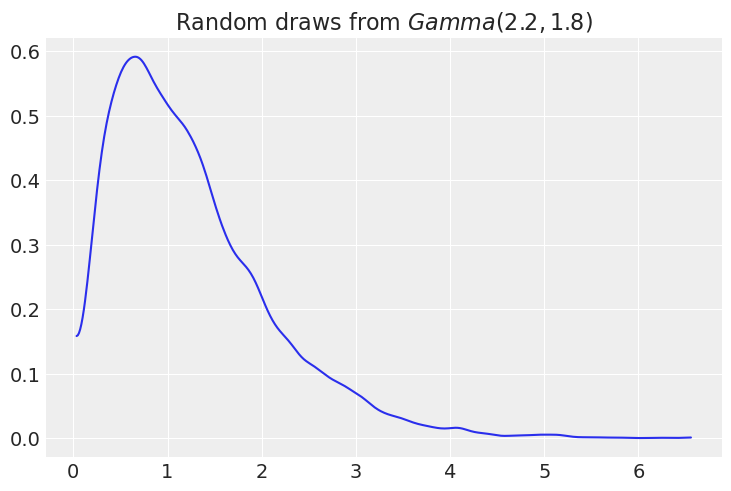

In [13]:
az.style.use("arviz-darkgrid")
ax = az.plot_dist(pm.Gamma.dist(**constrained_priors, size=10_000).eval())
ax.set_title(
    f"Random draws from $Gamma({round(constrained_priors['alpha'], 1)}, {round(constrained_priors['beta'], 1)})$"
);

Quite neat, right? Now we can use those parameters as priors for a Gamma distribution in a model: `pm.Gamma("my_wonderful_var", **constrained_priors)`!

Let's take another example, to drive the point home. Remember our Normal prior for the height of women? Let's try that now, imagining that we'd like 95% of the probability mass to be between 155cm and 180cm. That would mean:

In [14]:
constrained_priors = pm.find_constrained_prior(
    pm.Normal, lower=155, upper=180, mass=MASS, init_guess=dict(mu=170, sigma=3)
)

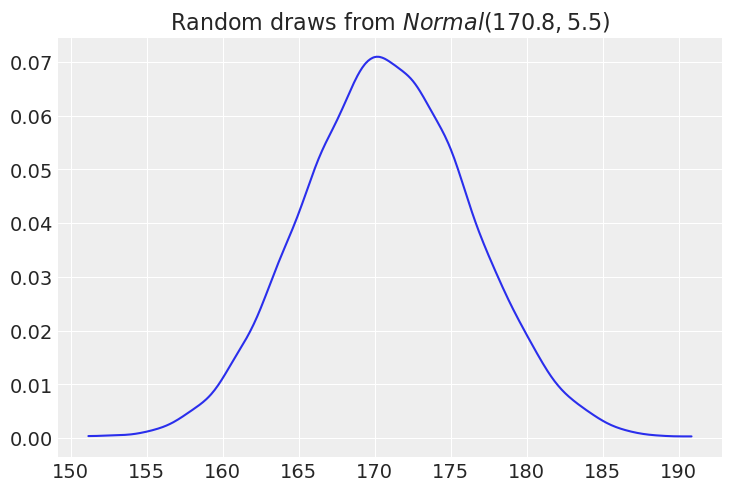

In [15]:
ax = az.plot_dist(pm.draw(pm.Normal.dist(**constrained_priors), draws=10_000))
ax.set_title(
    f"Random draws from $Normal({round(constrained_priors['mu'], 1)}, {round(constrained_priors['sigma'], 1)})$"
);

And... voilà!

![MicDrop](https://media.giphy.com/media/3o7qDSOvfaCO9b3MlO/giphy.gif)

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu May 19 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

arviz: 0.12.0
pymc : 4.0.0b6
sys  : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
numpy: 1.22.3

Watermark: 2.3.0

